# Imágenes biomédicas. Tarea 1.

**Comparación de métodos de segmentación por umbralización para imágenes de angiogramas coronarios**

***Diego Moreno***

En este reporte, se selecciona el método Local Sauvola del tipo Locally Adaptive Thresholding. En este método se utiliza la media y varianza de una ventana de la imagen de $15\times 15$ teniendo como resultado un threshold adaptado a cada píxel de la imagen. Con este threshold para cada píxel, se tomará la decisión si es fondo o es objeto. 

Se usan las imágenes de la base de datos de http://personal.cimat.mx:8181/~ivan.cruz/Databases.html. Al final del reporte se compara la segmentación contra el método de Ridler-Calvard en cuanto al promedio de cada métrica para toda la base de datos.

Importamos las librerías necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL

Mostramos una imagen de ejemplo, si no despliega nada, verificar que se tengan las imagenes en la carpeta deseada.

(2268, 4032)


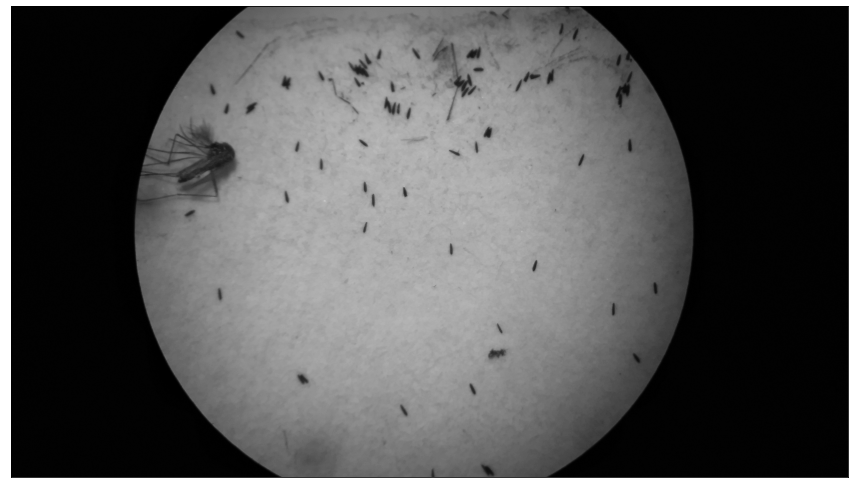

In [3]:
def readpgm(name):
    '''
    Función para leer imágenes en formato PGM
    '''
    with open(name) as f:
        lines = f.readlines()
    # This ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)
    # here,it makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2' 
    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])
    return (np.array(data[3:]),(data[1],data[0]),data[2])

pth = '/Users/damorgal/Documents/Master/Computer_vision/SEG1-A IMG_20220110_102730423 .jpg'
#img = cv2.imread(pth, cv2.IMREAD_GRAYSCALE).astype(float)/255
im = PIL.Image.open(pth)
img = np.array(im.convert("L"))
#img = np.reshape(data[0],data[1])
print(img.shape)
plt.figure(figsize=(15,10))
plt.imshow(img, "binary_r")
plt.xticks([]), plt.yticks([])
plt.show()

A continuación se muestra la función del algoritmo Local Sauvola para encontrar el threshold adaptable:

In [4]:
def padding(img, n=3):
    '''
    Función que le hace un padding a una imagen de tamaño n
    '''
    h = len(img)
    w = len(img[0])
    new_img = [[0 for i in range(w+2*n)] for i in range(h+2*n)]
    for i in range(h):
        for j in range(w):
            new_img[n+i][n+j] = img[i,j]
    return new_img

def local_sauvola(img, k=0.5, R=128, b=15):
    '''
    Función del algoritmo de Local Sauvola para encontrar los 
    thresholds adaptables de la imagen y segmentar el fondo.
    
    '''
    #Hacemos un padding para calcular la media y varianza de una ventana de 15x15
    b = b//2
    img_pad = padding(img, b)
    #Algoritmo
    new_img = [[0 for i in range(len(img[0]))] for j in range(len(img))]
    for i in range(len(img)):
        for j in range(len(img[0])):
            center = [b+i, b+j]
            window = [[img_pad[center[0]-b+i2][center[1]-b+j2] for j2 in range(2*b+1)] for i2 in range(2*b+1)]
            #Cálculo de local Sauvola
            threshold = np.mean(window) + (1 + k*(np.std(window)/R - 1))
            #Asignación de color
            if img[i][j] <= threshold:
                new_img[i][j] = 255
    return new_img

Se muestra un ejemplo de segmentación con Local Sauvola para una imagen:

In [6]:
img_ls = local_sauvola(img)
plt.figure(figsize=(15,10))
plt.imshow(img_ls, 'binary_r')
plt.xticks([]), plt.yticks([])
plt.show()

KeyboardInterrupt: 

A continuación el algoritmo de Ridler-Calvard para segmentación del fondo de la imagen:

In [7]:
def ridler_calvard(img, tolerance=0.001, n=256):
    img_aux = img*n
    m = np.mean(img_aux) # Initial estimation of the mean
    new_thresh = m
    while(1):
        prev_thresh = new_thresh
        threshold = round(prev_thresh)
        mb = np.mean(img_aux[img_aux <= threshold])
        mo = np.mean(img_aux[img_aux > threshold])
        new_thresh = (mb+mo)/2
        if abs(new_thresh-prev_thresh) <= tolerance:
            break
    return threshold/n

Un ejemplo de la segmentación dada por dicho algoritmo:

La frontera de umbralización encontrada es:
65.164062

Imagen generada con el threshold


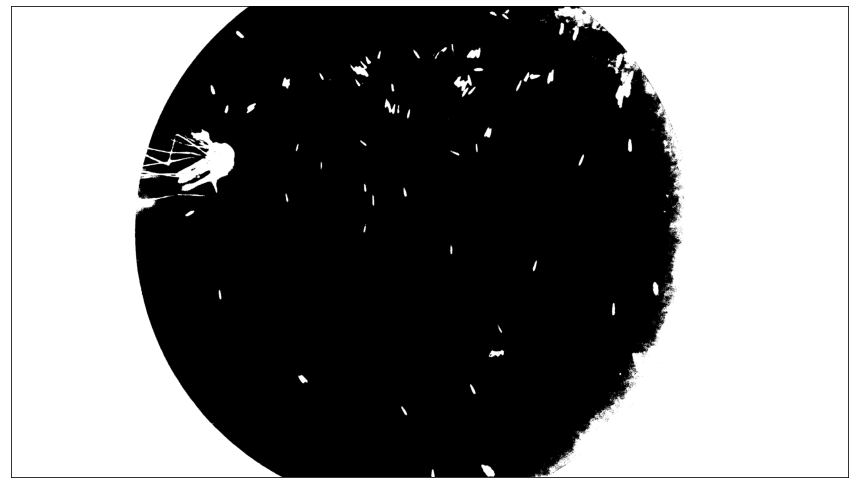

In [8]:
threshold = ridler_calvard(img)
print('La frontera de umbralización encontrada es:\n%f\n' % threshold)
print('Imagen generada con el threshold')
img_rc = np.array([[0 for i in range(len(img[0]))] for j in range(len(img))])
idx = img <= threshold
img_rc[idx] = 255

plt.figure(figsize=(15,10))
plt.imshow(img_rc, 'binary_r')
plt.xticks([]), plt.yticks([])
plt.show()

Luego, necesitamos comparar la segmentación obtenida por cada algoritmo contra una imagen de ground truth. A continuación se muestran las 2 imágenes obtenidas y el groud truth esperado:

Imagen generada con Local Sauvola	Imagen generada con Ridler-Cal.	Imagen generada con el threshold


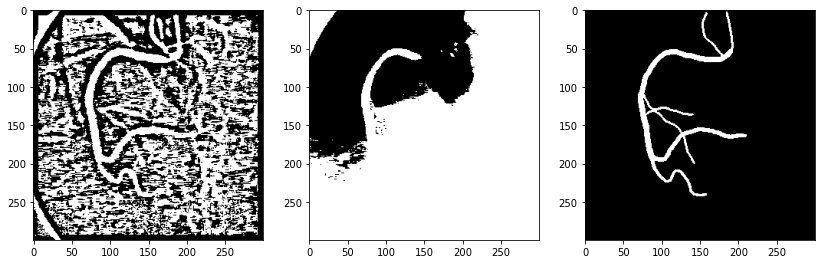

In [256]:
data = readpgm(pth + '1_gt.pgm')
img_gt = np.reshape(data[0],data[1])
print('Imagen generada con Local Sauvola\tImagen generada con Ridler-Cal.\tImagen generada con el threshold')
plt.figure(figsize=(14,20))
plt.subplot(131)
plt.imshow(img_ls, 'binary_r')
plt.subplot(132)
plt.imshow(img_rc, 'binary_r')
plt.subplot(133)
plt.imshow(img_gt, 'binary_r')
plt.show()

Para poder comparar las imágenes de manera cuantitativa, tenemos las siguientes métricas para cada una de las imágenes anteriores:

In [260]:
def metrics(img, img_gt):
    '''
    Función que regresa las siguientes cantidades de una imagen:
        True Positives  : tp 
        True Negatives  : tn
        False Positives : fp
        False Negatives : fn
    ordenados en una lista de la forma [tp, tn, fp, fn]
    '''
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img_gt[i][j]==255 and img[i][j]==255:
                tp += 1
            elif img_gt[i][j]==0 and img[i][j]==0:
                tn += 1
            elif img_gt[i][j]==0 and img[i][j]==255:
                fp += 1
            elif img_gt[i][j]==255 and img[i][j]==0:
                fn += 1
    return [tp, tn, fp, fn]

def sensitivity(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fn)

def specificity(tp=0, tn=0, fp=0, fn=0):
    return tn/(tn+fp)

def accuracy(tp=0, tn=0, fp=0, fn=0):
    return (tp+tn)/(tp+tn+fp+fn)

def pos_pred_val(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fp)

def neg_pred_val(tp=0, tn=0, fp=0, fn=0):
    return tn/(tn+fn)

def matthews_cc(tp=0, tn=0, fp=0, fn=0):
    return ((tp*tn) - (fp*fn))/((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**(1/2)

def jaccard(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fn+fp)

def dice(tp=0, tn=0, fp=0, fn=0):
    return 2*tp/(2*tp+fn+fp)

Comparamos ahora con las métricas dadas éstas imágenes:

In [264]:
loc_sau_metrics = metrics(img_ls, img_gt)
ridler_metrics = metrics(img_rc, img_gt)
print('Métricas para la imagen generada por Local Sauvola:')
print('Sensitivity: \t\t\t\t%.3f' % sensitivity(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]))
print('Specificity: \t\t\t\t%.3f' % specificity(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]))
print('Accuracy: \t\t\t\t%.3f' % accuracy(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]))
print('Positive Predictive Value: \t\t%.3f' % pos_pred_val(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]))
print('Negative Predictive Value: \t\t%.3f' % neg_pred_val(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]))
print('Matthews Correlation Coefficient: \t%.3f' % matthews_cc(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]))
print('Jaccard Index: \t\t\t\t%.3f' % jaccard(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]))
print('Dice Coefficient: \t\t\t%.3f' % dice(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]))

print('\nMétricas para la imagen generada por Ridler-Calvard:')
print('Sensitivity: \t\t\t\t%.3f' % sensitivity(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]))
print('Specificity: \t\t\t\t%.3f' % specificity(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]))
print('Accuracy: \t\t\t\t%.3f' % accuracy(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]))
print('Positive Predictive Value: \t\t%.3f' % pos_pred_val(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]))
print('Negative Predictive Value: \t\t%.3f' % neg_pred_val(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]))
print('Matthews Correlation Coefficient: \t%.3f' % matthews_cc(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]))
print('Jaccard Index: \t\t\t\t%.3f' % jaccard(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]))
print('Dice Coefficient: \t\t\t%.3f' % dice(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]))

Métricas para la imagen generada por Local Sauvola:
Sensitivity: 				0.957
Specificity: 				0.516
Accuracy: 				0.535
Positive Predictive Value: 		0.080
Negative Predictive Value: 		0.996
Matthews Correlation Coefficient: 	0.190
Jaccard Index: 				0.080
Dice Coefficient: 			0.147

Métricas para la imagen generada por Ridler-Calvard:
Sensitivity: 				0.823
Specificity: 				0.315
Accuracy: 				0.336
Positive Predictive Value: 		0.050
Negative Predictive Value: 		0.976
Matthews Correlation Coefficient: 	0.060
Jaccard Index: 				0.050
Dice Coefficient: 			0.094


Para esta imagen en específico, tenemos que hay una ligera mejora en el método de Sauvola, pues contiene un valor mayor de accuracy que el de Ridler-Calvard.

Finalmente, leemos todas las imágenes de la base de datos y reportaremos el promedio de las métricas totales de la base de datos.

In [269]:
#En total son 134 imágenes a leer
imgs = []
imgs_gt = []
for i in range(134):
    data = readpgm(pth + str(i+1) + '.pgm')
    img_aux = np.reshape(data[0],data[1])
    imgs.append(img_aux)
    data = readpgm(pth + str(i+1) + '_gt' + '.pgm')
    img_aux = np.reshape(data[0],data[1])
    imgs_gt.append(img_aux)

Realizamos el Local Sauvola para todas las imágenes:

In [271]:
local_sauvola_metrics = []
for i in range(134):
    img_ls = local_sauvola(imgs[i])
    #Metricas
    loc_sau_metrics = metrics(img_ls, imgs_gt[i])
    metrics_aux = [sensitivity(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]),
                   specificity(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]),
                   accuracy(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]),
                   pos_pred_val(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]),
                   neg_pred_val(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]),
                   matthews_cc(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]),
                   jaccard(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3]),
                   dice(loc_sau_metrics[0],loc_sau_metrics[1],loc_sau_metrics[2],loc_sau_metrics[3])]
    local_sauvola_metrics.append(metrics_aux)

Ahora el método de Ridler-Calvard para todas las imágenes:

In [272]:
ridler_calvard_metrics = []
for i in range(134):
    threshold = ridler_calvard(imgs[i])
    img_rc = np.array([[0 for i in range(len(imgs[i][0]))] for j in range(len(imgs[i]))])
    idx = imgs[i] <= threshold
    img_rc[idx] = 255
    #Metricas
    ridler_metrics = metrics(img_rc, imgs_gt[i])
    metrics_aux = [sensitivity(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]),
                   specificity(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]),
                   accuracy(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]),
                   pos_pred_val(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]),
                   neg_pred_val(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]),
                   matthews_cc(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]),
                   jaccard(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3]),
                   dice(ridler_metrics[0],ridler_metrics[1],ridler_metrics[2],ridler_metrics[3])]
    ridler_calvard_metrics.append(metrics_aux)


Para concluir, mostramos los promedios generales de las métricas obtenidas para las 134 imágenes:

In [273]:
local_sauvola_metrics_mean = np.mean(local_sauvola_metrics, axis=0)
ridler_calvard_metrics_mean = np.mean(ridler_calvard_metrics, axis=0)
print('Promedios de las métricas:\n\n')
print('Métricas del algoritmo de Local Sauvola:')
print('Sensitivity: \t\t\t\t%.3f' % local_sauvola_metrics_mean[0])
print('Specificity: \t\t\t\t%.3f' % local_sauvola_metrics_mean[1])
print('Accuracy: \t\t\t\t%.3f' % local_sauvola_metrics_mean[2])
print('Positive Predictive Value: \t\t%.3f' % local_sauvola_metrics_mean[3])
print('Negative Predictive Value: \t\t%.3f' % local_sauvola_metrics_mean[4])
print('Matthews Correlation Coefficient: \t%.3f' % local_sauvola_metrics_mean[5])
print('Jaccard Index: \t\t\t\t%.3f' % local_sauvola_metrics_mean[6])
print('Dice Coefficient: \t\t\t%.3f' % local_sauvola_metrics_mean[7])

print('\nMétricas para la imagen generada por Ridler-Calvard:')
print('Sensitivity: \t\t\t\t%.3f' % ridler_calvard_metrics_mean[0])
print('Specificity: \t\t\t\t%.3f' % ridler_calvard_metrics_mean[1])
print('Accuracy: \t\t\t\t%.3f' % ridler_calvard_metrics_mean[2])
print('Positive Predictive Value: \t\t%.3f' % ridler_calvard_metrics_mean[3])
print('Negative Predictive Value: \t\t%.3f' % ridler_calvard_metrics_mean[4])
print('Matthews Correlation Coefficient: \t%.3f' % ridler_calvard_metrics_mean[5])
print('Jaccard Index: \t\t\t\t%.3f' % ridler_calvard_metrics_mean[6])
print('Dice Coefficient: \t\t\t%.3f' % ridler_calvard_metrics_mean[7])

Promedios de las métricas:


Métricas del algoritmo de Local Sauvola:
Sensitivity: 				0.931
Specificity: 				0.524
Accuracy: 				0.546
Positive Predictive Value: 		0.101
Negative Predictive Value: 		0.992
Matthews Correlation Coefficient: 	0.205
Jaccard Index: 				0.100
Dice Coefficient: 			0.182

Métricas para la imagen generada por Ridler-Calvard:
Sensitivity: 				0.655
Specificity: 				0.594
Accuracy: 				0.597
Positive Predictive Value: 		0.128
Negative Predictive Value: 		0.972
Matthews Correlation Coefficient: 	0.150
Jaccard Index: 				0.112
Dice Coefficient: 			0.180


Como conclusión, podemos notar que el el algoritmo de Sauvola cuenta con mucha sensitividad en comparación con el otro método. Sin embargo, para la especificidad y la accuracy el método simple de Ridler-Clavard logra mejor desempeño en promedio llegando a casi 0.6 de accuracy y quedando corto el método de Sauvola con 0.54.

Notablemente, ambos métodos tienen un valor bajo de valores positivos predichos pues estos corresponderían a los vasos sanguíneos. Similarmente, ambos métodos tienen un valor alto de valores negativos predichos. Los coeficientes de Matthews, jaccard y Dice se nota que no hay una diferencia significativa.

Si solo compararamos accuracy, nos iriamos por el método de Ridler-Calvard, sin embargo, dependiendo de nuestro interés, podríamos seleccionar el método de mayor sensitividad que en ese caso sería el Sauvola.